# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

Fuente: https://github.com/Yangyangii/GAN-Tutorial


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_8/GANs'

Mounted at /content/drive


In [6]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# defino el tamaño del vector del ruido del cual deseo generar a imagen.
n_noise = 100

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=n_noise, num_classes=784): # input_size lo elijo yo,
                                                             # es el vector de números aleatorios del cual deseo partir.
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28) # la salida le doy formato de imagen de MNIST [batchx1x28x28]
        return y_

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1): # input_size, la imagen MNIST vectorizada, num_classes=1 (REAL or FAKE)
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1) # vectorizo la imagen MNIST
        y_ = self.layer(y_)
        return y_

In [10]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # genero un batch de 100 vectores randn
                                            # del tamaño definido en n_noise.
    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [11]:
# instancio los modelos
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)


In [12]:
# puedo cargar un modelo ya entrenado
D.load_state_dict(torch.load(data_dir + '/D_nnoise_100_e_100.pkl', map_location=DEVICE, weights_only=False))


<All keys matched successfully>

In [13]:
G.load_state_dict(torch.load(data_dir + '/G_nnoise_100_e_100.pkl', map_location=DEVICE, weights_only=False))

<All keys matched successfully>

In [14]:
# transformación para normalizar el dataset.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [15]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]


In [16]:
batch_size = 32 #32 original

In [17]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
max_epoch = 15 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [20]:
D_true = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [21]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [24]:
step = 0
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        # el discriminador debe ser entenado para poder reconocer imagenes
        # REAL vs FAKE

        # le paso imagenes de verdad y etiquetas de verdad.
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_true)
        D_x = x_outputs.mean().item() # almaceno el valor medio de la predicción de D of x

        # le paso imágenes falsas y etiquetas falsas.
        z = torch.randn(batch_size, n_noise).to(DEVICE) # vector randn
        fake_im = G(z) # genero con el generador
        z_outputs = D(fake_im) # las paso por el Discriminador
        D_z_loss = criterion(z_outputs, D_fakes) # comparo con etiquetas FAKE
        D_z = z_outputs.mean().item() # almaceno el valor medio de la predicción de D of z

        # perdida total discriminador
        D_loss = D_x_loss + D_z_loss # sumo ambas pérdidas

        # optimizo el Discriminador
        D.zero_grad()
        D_loss.backward()
        D_opt.step()


        if step % n_critic == 0:
            # Training Generator
            # el Generador, debe ser entrenado para engañar al Discriminador!
            # para esto, le paso imágenes falsas al Discriminador, CON ETIQUETAS REALES!
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs_2 = D(G(z))
            G_loss = criterion(z_outputs_2, D_true)
            D_G_z = z_outputs_2.mean().item() # almaceno el valor medio de la predicón de D of G of z

            # optimizo SOLO el Generador
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # lineas plara sacar resultados parciales o imágenes parciales
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {:.2f}, G Loss: {:.2f}, D(x): {:.2f}, D(z): {:.2f}, D(G(z)): {:.2f} '.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), D_x, D_z, D_G_z))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/30, Step: 0, D Loss: 1.27, G Loss: 1.17, D(x): 0.52, D(z): 0.36, D(G(z)): 0.36 
Epoch: 0/30, Step: 500, D Loss: 1.21, G Loss: 1.24, D(x): 0.67, D(z): 0.50, D(G(z)): 0.35 
Epoch: 0/30, Step: 1000, D Loss: 1.16, G Loss: 1.29, D(x): 0.67, D(z): 0.45, D(G(z)): 0.34 
Epoch: 0/30, Step: 1500, D Loss: 1.20, G Loss: 1.46, D(x): 0.67, D(z): 0.48, D(G(z)): 0.30 
Epoch: 1/30, Step: 2000, D Loss: 1.31, G Loss: 1.55, D(x): 0.62, D(z): 0.46, D(G(z)): 0.27 
Epoch: 1/30, Step: 2500, D Loss: 1.15, G Loss: 1.19, D(x): 0.55, D(z): 0.34, D(G(z)): 0.36 
Epoch: 1/30, Step: 3000, D Loss: 1.24, G Loss: 1.11, D(x): 0.57, D(z): 0.43, D(G(z)): 0.38 
Epoch: 1/30, Step: 3500, D Loss: 1.14, G Loss: 1.24, D(x): 0.65, D(z): 0.39, D(G(z)): 0.35 
Epoch: 2/30, Step: 4000, D Loss: 1.05, G Loss: 0.97, D(x): 0.63, D(z): 0.38, D(G(z)): 0.43 
Epoch: 2/30, Step: 4500, D Loss: 1.31, G Loss: 1.34, D(x): 0.57, D(z): 0.41, D(G(z)): 0.30 
Epoch: 2/30, Step: 5000, D Loss: 0.91, G Loss: 1.27, D(x): 0.64, D(z): 0.31, D(G(z))

## Visualize Sample

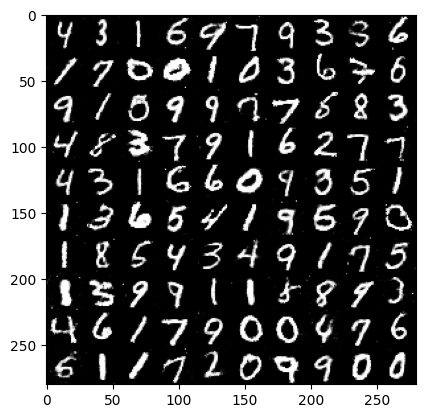

In [25]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
# Saving params.
#torch.save(D.state_dict(), data_dir + '/D_nnoise_100_e_100.pkl')
#torch.save(G.state_dict(), data_dir + '/G_nnoise_100_e_100.pkl')

In [27]:
def get_sample_image_col(G, n_noise, z):
    """
        save sample 100 images
    """

    # lo repito 100 veces para generas 100 imagenes
    z2 =  z.repeat(100, 1)

    # defino un spam de valores para reemplazar en una columna
    # recuerdo que mi generador es una randn (distribución normal con media=0 y varianza=1)
    # por lo que en -3 a +3 tendré el 99.9% de los valores que pude haber visto el G
    a = torch.linspace(-3,3,100)

    # elejir que columna deseo reemplazar
    # la cambio a azar
    n = np.random.randint(n_noise)
    print(f'Columna variada: {n}')
    #n = 92
    z2[:,n] = a

    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z2).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img


In [28]:
n_noise

100

In [29]:
# genero un batch de 1 vector randn del tamaño definido en n_noise que voy a utilizar en lo que sigue
z = torch.randn(1, n_noise).to(DEVICE)

In [30]:
z

tensor([[ 1.6532,  0.7939, -0.6266, -0.2983, -0.3377,  0.2705,  0.9540,  0.1665,
         -0.4484, -1.1329,  0.4479,  0.0984,  1.5242,  0.6860,  1.1095,  1.6920,
          0.3595,  2.1646, -0.2752,  0.1354,  0.9238, -2.3522, -0.0034,  1.7663,
         -0.1883, -0.4689, -0.5782,  0.6421,  0.6432, -0.5401,  2.2153, -0.3774,
          0.3227, -0.6153, -2.8313, -0.2191,  0.4559,  1.0142,  0.9116,  0.7445,
         -1.2815, -1.3875, -0.0276,  1.4892,  1.0344, -0.7431,  0.3901,  2.4885,
          0.9107, -0.8411,  0.1917,  1.7701, -0.5697,  0.0840, -1.3473,  0.5513,
          0.0911,  0.2244,  0.0913,  0.4463, -0.9417,  0.4388, -1.6771, -1.5406,
          2.3729,  0.9480, -0.9743,  1.0967, -0.7271, -0.8255, -0.4920,  0.0158,
          0.3646,  1.2599, -0.0220, -1.0104, -0.0142, -0.6819,  1.0479,  0.7681,
          0.2624,  1.9882,  0.3323,  0.9564, -1.0449,  0.2754, -0.6491, -0.2631,
         -1.6522,  1.9420,  0.5143, -1.0426,  0.0723,  1.5067, -0.8142,  0.4617,
          0.9920, -0.7913, -

In [ ]:
imshow(get_sample_image_col(G, n_noise, z), cmap='gray')

In [ ]:
z